Nesta abordagem, o treinamento ocorre da mesma forma que na forma retroalimentada, a diferença está
em como testamos o modelo. O conjunto de teste é formado através de uma janela que vai avançando a medida
que os dados são preditos.

In [4]:
# imports
%matplotlib inline
import pandas
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time
import datetime
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from estatisticas_time_serie import generate_datasets,general_forecasting,smooth
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

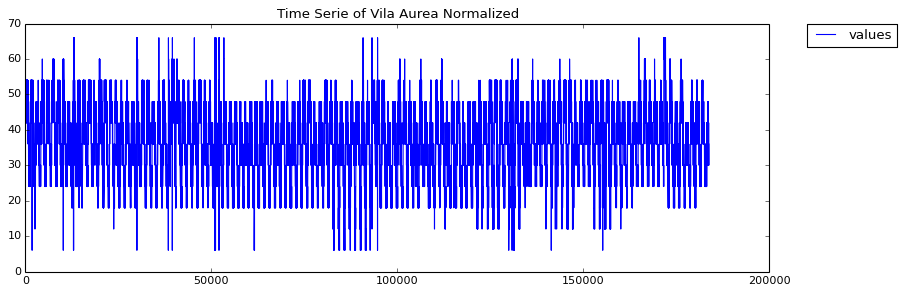

In [8]:
# load the first dataset vilacarvalho-vazao-60
dataframe = pandas.read_csv('690a-vazao-vila-aurea-20-04-2016.csv', engine='python', skipfooter=3)
data_matrix = dataframe.as_matrix()
data_matrix = data_matrix[340519:,2:]

data_convolution = np.array(data_matrix).ravel()

newV=[]
for idx,val in enumerate(data_convolution):
    if not data_convolution[idx] == 'null' and not np.isnan(data_convolution[idx]): 
        newV.append(float(data_convolution[idx]))

newV = np.array(newV)
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
newV = reject_outliers(newV)


plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(newV,label='values')
plt.title('Time Serie of Vila Aurea Normalized')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

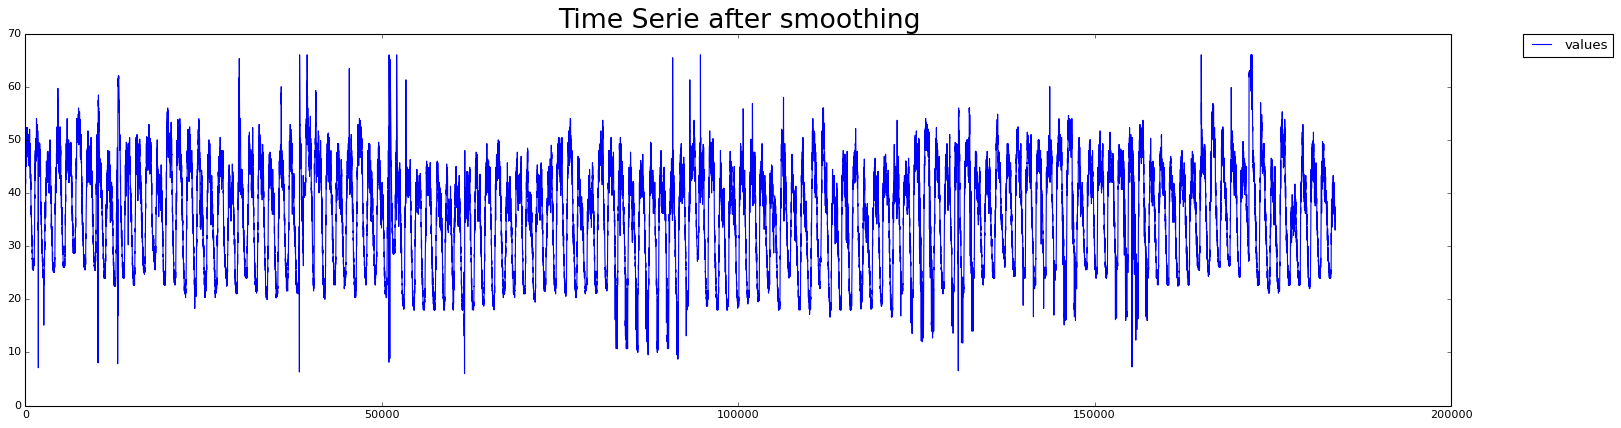

In [9]:
# preprocessing
newV = smooth(newV, 10, window='hanning')

plt.figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(newV,label='values')
plt.title('Time Serie after smoothing',fontsize=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
train_data,test_data, y_seq = generate_datasets(newV, look_back=420, pred_horizon=6)
# Using lstm
scaler = MinMaxScaler(feature_range=(0, 1))
# normalize the dataset
datasetLstm = scaler.fit_transform(newV)
train_data_lstm, test_data_lstm, y_seq_lstm = generate_datasets(datasetLstm, look_back = 420, pred_horizon=6)

In [5]:
trainX, trainY = train_data[0],train_data[1]
testX, testY   = test_data[0], test_data[1]
trainXlstm, trainYlstm = train_data_lstm[0], train_data_lstm[1]
testXlstm, testYlstm   = test_data_lstm[0], test_data_lstm[1]
# reshape input to be [samples, time steps, features]
trainXlstm = np.reshape(trainXlstm, (trainXlstm.shape[0], 1, trainXlstm.shape[1]))
testXlstm = np.reshape(testXlstm, (testXlstm.shape[0], 1, testXlstm.shape[1]))

In [12]:
# KNN
clf_KNN = KNeighborsRegressor(n_neighbors=1)
clf_KNN.fit(trainX, trainY)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [13]:
# SVM
print("training svm")
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing.StandardScaler()),
    ('classify', SVR(kernel='rbf', max_iter=1000,verbose=True)),
])

params_list = {"classify__C": [0.01,1.0,10],'classify__epsilon': [0.01,0.1,0.2] }
#n_iter_search=20
random_search = GridSearchCV(pipeline, param_grid=params_list, n_jobs=-1, cv=TimeSeriesSplit(n_splits=2))
random_search.fit(trainX, trainY)
clf_SVM = random_search
#clf_SVM.fit(trainX, trainY)
print("training finished")

training svm
[LibSVM]training finished


In [14]:
print("training lstm")
#LSTM
model = Sequential()
model.add(LSTM(10, input_dim=420))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainXlstm, trainYlstm, nb_epoch=10, batch_size=128, verbose=1)

training lstm
Epoch 1/10
146558/146558 [==============================] - 16s - loss: 0.0018    
Epoch 2/10
146558/146558 [==============================] - 15s - loss: 4.7026e-04    
Epoch 3/10
146558/146558 [==============================] - 15s - loss: 3.2021e-04    
Epoch 4/10
146558/146558 [==============================] - 16s - loss: 2.6390e-04    
Epoch 5/10
146558/146558 [==============================] - 15s - loss: 2.3084e-04    
Epoch 6/10
146558/146558 [==============================] - 16s - loss: 2.0174e-04    
Epoch 7/10
146558/146558 [==============================] - 16s - loss: 1.8661e-04    
Epoch 8/10
146558/146558 [==============================] - 16s - loss: 1.7554e-04    
Epoch 9/10
146558/146558 [==============================] - 16s - loss: 1.5727e-04    
Epoch 10/10
146558/146558 [==============================] - 15s - loss: 1.4970e-04    


In [13]:
#predicting
print("knn")
forecast_KNN = general_forecasting(testX, clf_KNN, slidding_window_len=6, strategy_approach='sliding_windows')
print("lstm")
forecast_LSTM = general_forecasting(testXlstm, model, strategy_approach='sliding_windows', slidding_window_len=6)

knn
lstm


In [7]:
print("svm")
forecast_SVM =  general_forecasting(testX, clf_SVM, strategy_approach='sliding_windows',slidding_window_len=6)

svm


In [14]:
# rescaling back to initial dimension
forecast_LSTM = scaler.inverse_transform(forecast_LSTM)

In [8]:
print("mean_squared_error  SVM = ",mean_squared_error(y_seq,forecast_SVM))

('mean_squared_error  SVM = ', 14.891773944800391)


In [15]:
print("mean_squared_error  KNN = ",mean_squared_error(y_seq,forecast_KNN))
print("mean_squared_error  LSTM = ",mean_squared_error(y_seq,forecast_LSTM))

('mean_squared_error  KNN = ', 10.502820051296521)
('mean_squared_error  LSTM = ', 4.5697546116172383)


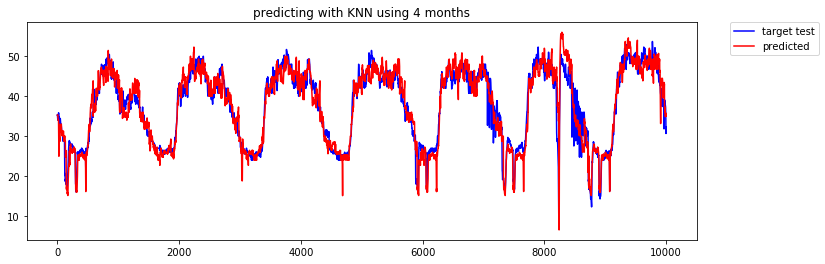

In [16]:
#plotting knn results
testPredictPlot = np.empty((len(testY)))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_KNN[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with KNN using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

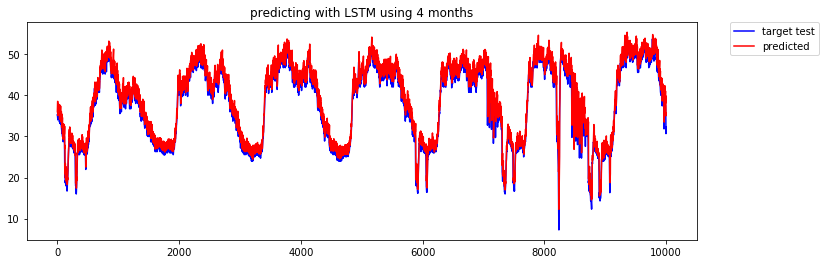

In [17]:
#plotting lstm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_LSTM[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with LSTM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

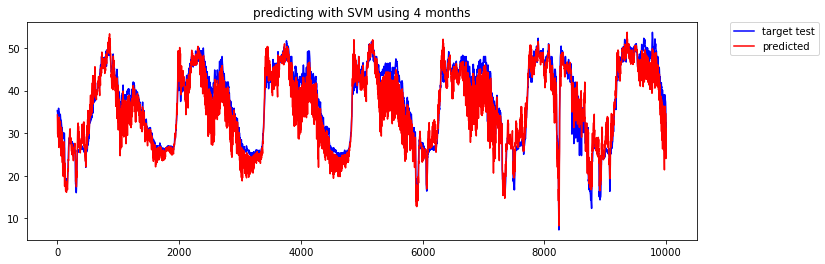

In [18]:
#plotting svm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_SVM[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with SVM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# 

In [19]:
train_data,test_data, y_seq = generate_datasets(newV, look_back=420, pred_horizon=30)
# Using lstm
scaler = MinMaxScaler(feature_range=(0, 1))
# normalize the dataset
datasetLstm = scaler.fit_transform(newV)
train_data_lstm, test_data_lstm, y_seq_lstm = generate_datasets(datasetLstm ,look_back = 420, pred_horizon=30)

In [20]:
trainX, trainY = train_data[0],train_data[1]
testX, testY   = test_data[0], test_data[1]
trainXlstm, trainYlstm = train_data_lstm[0], train_data_lstm[1]
testXlstm, testYlstm   = test_data_lstm[0], test_data_lstm[1]
# reshape input to be [samples, time steps, features]
trainXlstm = np.reshape(trainXlstm, (trainXlstm.shape[0], 1, trainXlstm.shape[1]))
testXlstm = np.reshape(testXlstm, (testXlstm.shape[0], 1, testXlstm.shape[1]))

In [21]:
#predicting
print("knn")
forecast_KNN = general_forecasting(testX, clf_KNN, slidding_window_len=30 ,method='knn', strategy_approach='sliding_windows')
print("lstm")
forecast_LSTM = general_forecasting(testXlstm, model,method='lstm', strategy_approach='sliding_windows', slidding_window_len=30)
print("svm")
forecast_SVM =  general_forecasting(testX, clf_SVM, strategy_approach='sliding_windows',slidding_window_len=30)

knn
lstm
svm


In [22]:
# rescaling back to initial dimension
forecast_LSTM = scaler.inverse_transform(forecast_LSTM)

In [23]:
print("mean_squared_error  KNN = ",mean_squared_error(y_seq,forecast_KNN))
print("mean_squared_error  SVM = ",mean_squared_error(y_seq,forecast_SVM))
print("mean_squared_error  LSTM = ",mean_squared_error(y_seq,forecast_LSTM))

('mean_squared_error  KNN = ', 13.045762359760271)
('mean_squared_error  SVM = ', 137.98456107689253)
('mean_squared_error  LSTM = ', 61.992745793819189)


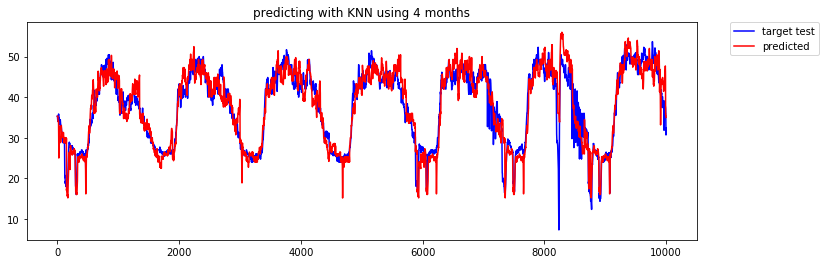

In [24]:
#plotting knn results
testPredictPlot = np.empty((len(testY)))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_KNN[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with KNN using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

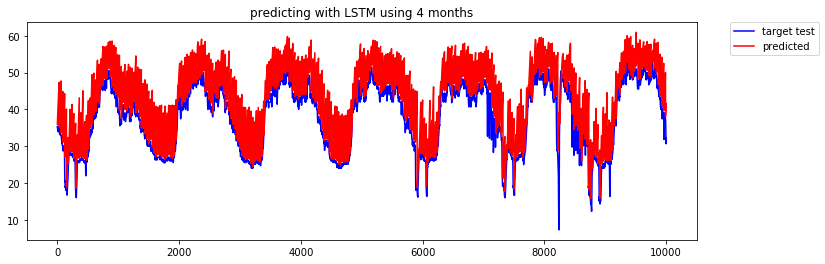

In [25]:
#plotting lstm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_LSTM[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with LSTM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

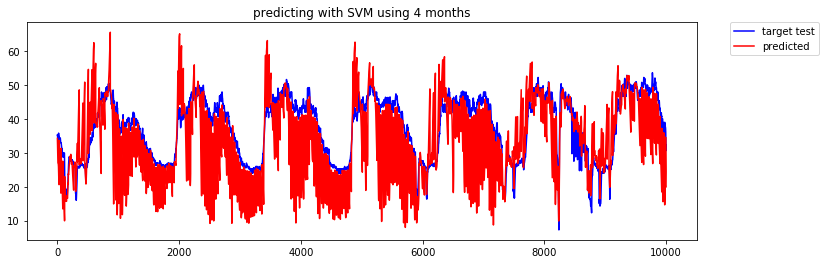

In [26]:
#plotting svm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_SVM[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with SVM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
train_data,test_data, y_seq = generate_datasets(newV, look_back=420, pred_horizon=60)
# Using lstm
scaler = MinMaxScaler(feature_range=(0, 1))
# normalize the dataset
datasetLstm = scaler.fit_transform(newV)
train_data_lstm, test_data_lstm, y_seq_lstm = generate_datasets(datasetLstm,look_back = 420, pred_horizon=60)

In [11]:
trainX, trainY = train_data[0],train_data[1]
testX, testY   = test_data[0], test_data[1]
trainXlstm, trainYlstm = train_data_lstm[0], train_data_lstm[1]
testXlstm, testYlstm   = test_data_lstm[0], test_data_lstm[1]
# reshape input to be [samples, time steps, features]
trainXlstm = np.reshape(trainXlstm, (trainXlstm.shape[0], 1, trainXlstm.shape[1]))
testXlstm = np.reshape(testXlstm, (testXlstm.shape[0], 1, testXlstm.shape[1]))

In [15]:
#predicting
print("knn")
forecast_KNN = general_forecasting(testX, clf_KNN, slidding_window_len=60 ,method='knn', strategy_approach='sliding_windows')
print("lstm")
forecast_LSTM = general_forecasting(testXlstm, model,method='lstm', strategy_approach='sliding_windows', slidding_window_len=60)
print("svm")
forecast_SVM =  general_forecasting(testX, clf_SVM, strategy_approach='sliding_windows',slidding_window_len=60)

knn
lstm
svm


In [16]:
# rescaling back to initial dimension
forecast_LSTM = scaler.inverse_transform(forecast_LSTM)

In [17]:
print("mean_squared_error  KNN = ",mean_squared_error(y_seq,forecast_KNN))
print("mean_squared_error  SVM = ",mean_squared_error(y_seq,forecast_SVM))
print("mean_squared_error  LSTM = ",mean_squared_error(y_seq,forecast_LSTM))

('mean_squared_error  KNN = ', 15.726788973068357)
('mean_squared_error  SVM = ', 170.16613532529072)
('mean_squared_error  LSTM = ', 18.996531636502496)


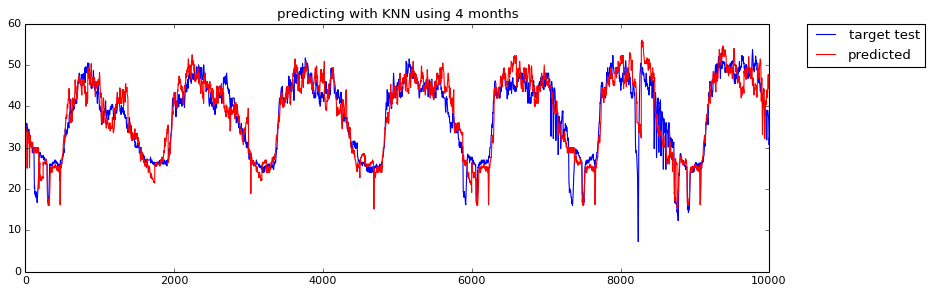

In [21]:
#plotting knn results
testPredictPlot = np.empty((len(testY)))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_KNN[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with KNN using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

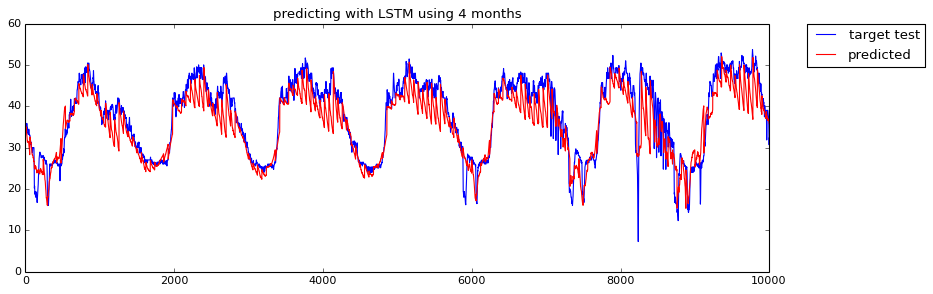

In [22]:
#plotting lstm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_LSTM[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with LSTM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

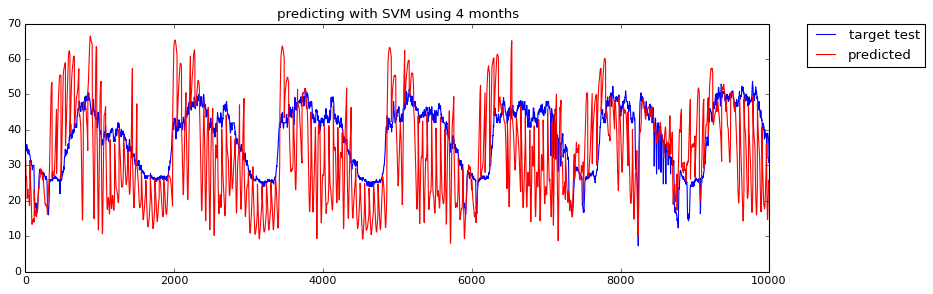

In [23]:
#plotting svm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_SVM[:10000]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_seq[:10000],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with SVM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()